# Hands-on exercise

## Loading modules

In [1]:
import subprocess

from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process import kernels
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.cm as cm
import matplotlib.pyplot as plt

from scipy.linalg import lapack
from scipy import stats
import emcee
import numpy as np

import importlib

import os
import pickle
from pathlib import Path

import src.reader as Reader

## Step 1: prepare input file

### Load stuff from text files

In [2]:
# Read data files
RawData1 = Reader.ReadData('input/AJExample/Data_Selection1.dat')
RawData2 = Reader.ReadData('input/AJExample/Data_Selection2.dat')

# Read covariance -- if you have covariance matrix from the experiments for example
# RawCov1 = Reader.ReadCovariance('input/AJExample/______.dat')
# RawCov2 = Reader.ReadCovariance('input/AJExample/______.dat')

# Read design points
RawDesign = Reader.ReadDesign('input/AJExample/Design.dat')

# Read model prediction
RawPrediction1 = Reader.ReadPrediction('input/AJExample/Prediction_Selection1.dat')
RawPrediction2 = Reader.ReadPrediction('input/AJExample/Prediction_Selection2.dat')

### Setup analysis

In [3]:
# Initialize empty dictionary
AllData = {}

# Basic information
AllData["systems"] = ["PbPb5020"]
AllData["keys"] = RawDesign["Parameter"]
AllData["labels"] = RawDesign["Parameter"]
AllData["ranges"] = [(0, 1.0), (0, 1.0), (0, 0.5)]
AllData["observables"] = [('A_J', ['C0', 'C1'])]

# Data points
Data = {"PbPb5020": {"A_J": {"C0": RawData1["Data"], "C1": RawData2["Data"]}}}

# Model predictions
Prediction = {"PbPb5020": {"A_J": {"C0": {"Y": RawPrediction1["Prediction"], "x": RawData1["Data"]['x']},
                                   "C1": {"Y": RawPrediction2["Prediction"], "x": RawData2["Data"]['x']}}}}

# Covariance length toggles
# Change to 9999 to make it fully correlated,or -1 for fully uncorrelated
CovarianceLength = -1

# Covariance matrices - the indices are [system][measurement1][measurement2], each one is a block of matrix
Covariance = Reader.InitializeCovariance(Data)
Covariance["PbPb5020"][("A_J", "C0")][("A_J", "C0")] = Reader.EstimateCovariance(RawData1, RawData1, SysLength = {"default": CovarianceLength})
Covariance["PbPb5020"][("A_J", "C1")][("A_J", "C1")] = Reader.EstimateCovariance(RawData2, RawData2, SysLength = {"default": CovarianceLength})
Covariance["PbPb5020"][("A_J", "C0")][("A_J", "C1")] = Reader.EstimateCovariance(RawData1, RawData2, SysLength = {"default": CovarianceLength})
Covariance["PbPb5020"][("A_J", "C1")][("A_J", "C0")] = Reader.EstimateCovariance(RawData2, RawData1, SysLength = {"default": CovarianceLength})

# Assign data to the dictionary
AllData["design"] = RawDesign["Design"]
AllData["model"] = Prediction
AllData["data"] = Data
AllData["cov"] = Covariance

# Save to the desired pickle file
with open('input/default.p', 'wb') as handle:
    pickle.dump(AllData, handle, protocol = pickle.HIGHEST_PROTOCOL)

## Plotting inputs

Text(0, 0.5, 'Peripheral')

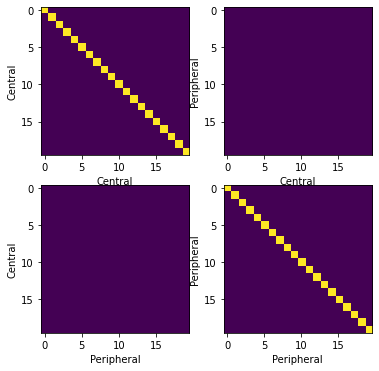

In [4]:
MaxValue = np.array([Covariance["PbPb5020"][("A_J", "C0")][("A_J", "C0")].max(), Covariance["PbPb5020"][("A_J", "C0")][("A_J", "C1")].max(), Covariance["PbPb5020"][("A_J", "C1")][("A_J", "C0")].max(), Covariance["PbPb5020"][("A_J", "C1")][("A_J", "C1")].max()]).max()

figure, axes = plt.subplots(figsize = (6, 6), ncols = 2, nrows = 2)
axes[0][0].imshow(Covariance["PbPb5020"][("A_J", "C0")][("A_J", "C0")], vmin=0, vmax=MaxValue)
axes[0][1].imshow(Covariance["PbPb5020"][("A_J", "C0")][("A_J", "C1")], vmin=0, vmax=MaxValue)
axes[1][0].imshow(Covariance["PbPb5020"][("A_J", "C1")][("A_J", "C0")], vmin=0, vmax=MaxValue)
axes[1][1].imshow(Covariance["PbPb5020"][("A_J", "C1")][("A_J", "C1")], vmin=0, vmax=MaxValue)

axes[0][0].set_xlabel('Central')
axes[0][1].set_xlabel('Central')
axes[1][0].set_xlabel('Peripheral')
axes[1][1].set_xlabel('Peripheral')

axes[0][0].set_ylabel('Central')
axes[0][1].set_ylabel('Peripheral')
axes[1][0].set_ylabel('Central')
axes[1][1].set_ylabel('Peripheral')


### Optional: clean past files

In [5]:
# Clean past MCMC samples
if os.path.exists('cache/mcmc_chain.hdf'):
    os.remove("cache/mcmc_chain.hdf")

# Clean past emulator
for system in AllData["systems"]:
    if os.path.exists('cache/emulator/' + system + ".pkl"):
        os.remove('cache/emulator/' + system + ".pkl")

## Step 2: run emulator

In [6]:
! python3 -m src.emulator --retrain --npc 10

[INFO][emulator] training emulator for system PbPb5020 (10 PC, 0 restarts)
[1.  1.  0.5]
[INFO][emulator] writing cache file cache/emulator/PbPb5020.pkl
PbPb5020
10 PCs explain 0.99882 of variance
GP 0: 0.54557 of variance, LML = -8.0825, kernel: Matern(length_scale=[1.07, 2.49, 0.372], nu=1.5) + WhiteKernel(noise_level=0.0204)
GP 1: 0.20910 of variance, LML = -22.254, kernel: Matern(length_scale=[0.504, 0.955, 0.238], nu=1.5) + WhiteKernel(noise_level=2.23e-08)
GP 2: 0.11308 of variance, LML = -37.383, kernel: Matern(length_scale=[0.453, 1.62, 0.223], nu=1.5) + WhiteKernel(noise_level=0.118)
GP 3: 0.06815 of variance, LML = -31.053, kernel: Matern(length_scale=[0.748, 0.847, 0.113], nu=1.5) + WhiteKernel(noise_level=6.93e-09)
GP 4: 0.03637 of variance, LML = -21.057, kernel: Matern(length_scale=[1.26, 10, 0.0555], nu=1.5) + WhiteKernel(noise_level=5.77e-10)
GP 5: 0.01013 of variance, LML = -43.765, kernel: Matern(length_scale=[0.16, 3.6, 0.0574], nu=1.5) + WhiteKernel(noise_level=7.08

In [7]:
from src import lazydict, emulator
EmulatorPbPb5020 = emulator.Emulator.from_cache('PbPb5020')

## Step 3: MCMC sampling

In [15]:
if os.path.exists('cache/mcmc_chain.hdf'):
    os.remove("cache/mcmc_chain.hdf")
! python3 -m src.mcmc --nwalkers 100 --nburnsteps 1000 500

[INFO][mcmc] no existing chain found, starting initial burn-in
[INFO][mcmc] running 100 walkers for 500 steps
[INFO][mcmc] step 50: acceptance fraction: mean 0.3250, std 0.1423, min 0.0000, max 0.5800
[INFO][mcmc] step 100: acceptance fraction: mean 0.3516, std 0.1440, min 0.0400, max 0.5500
[INFO][mcmc] step 150: acceptance fraction: mean 0.3664, std 0.1446, min 0.0333, max 0.5667
[INFO][mcmc] step 200: acceptance fraction: mean 0.3702, std 0.1453, min 0.0250, max 0.5700
[INFO][mcmc] step 250: acceptance fraction: mean 0.3750, std 0.1444, min 0.0280, max 0.5360
[INFO][mcmc] step 300: acceptance fraction: mean 0.3780, std 0.1422, min 0.0233, max 0.5433
[INFO][mcmc] step 350: acceptance fraction: mean 0.3845, std 0.1402, min 0.0229, max 0.5400
[INFO][mcmc] step 400: acceptance fraction: mean 0.3913, std 0.1375, min 0.0200, max 0.5450
[INFO][mcmc] step 450: acceptance fraction: mean 0.3951, std 0.1358, min 0.0178, max 0.5467
[INFO][mcmc] step 500: acceptance fraction: mean 0.3965, std 0.

## Step 4: Analyze posterior samples

In [16]:
import src
src.Initialize()
from src import mcmc
chain = mcmc.Chain()
MCMCSamples = chain.load()

## Step 5: adding all sorts of plots

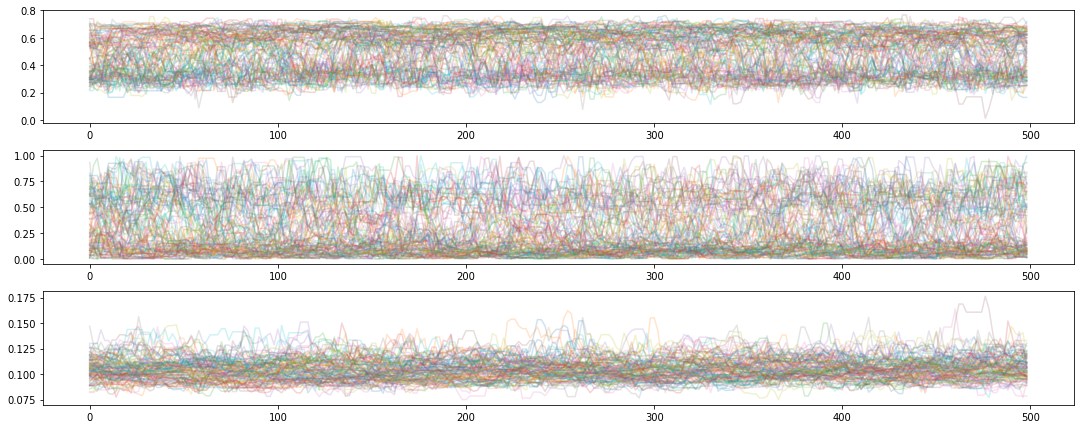

In [17]:
with chain.dataset() as d:
    W = d.shape[0]     # number of walkers
    S = d.shape[1]     # number of steps
    N = d.shape[2]     # number of paramters
    T = int(S / 200)   # "thinning"
    A = 20 / W
    figure, axes = plt.subplots(figsize = (15, 2 * N), ncols = 1, nrows = N)
    for i, ax in enumerate(axes):
        for j in range(0, W):
            ax.plot(range(0, S, T), d[j, ::T, i], alpha = A)
    plt.tight_layout(True)
    plt.savefig('MCMCSamples.pdf', dpi = 192)

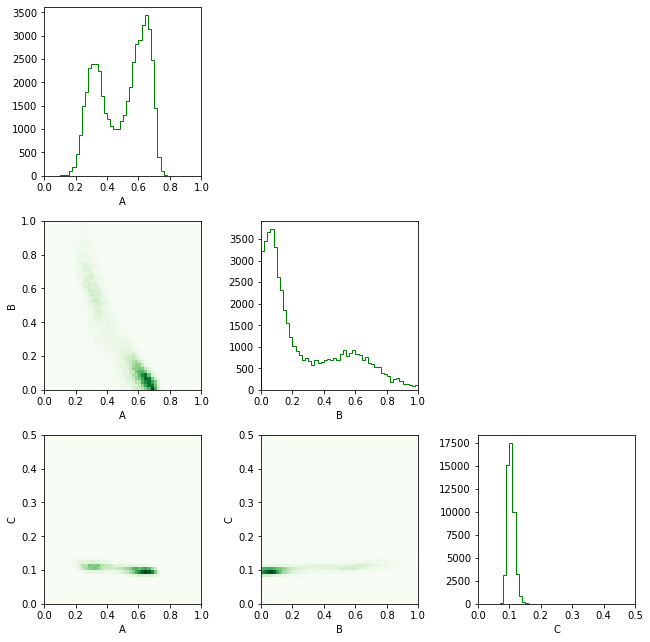

In [18]:
NDimension = len(AllData["labels"])
Ranges = np.array(AllData["ranges"]).T
figure, axes = plt.subplots(figsize = (3 * NDimension, 3 * NDimension), ncols = NDimension, nrows = NDimension)
Names = AllData["labels"]
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        if i==j:
            ax.hist(MCMCSamples[:,i], bins=50,
                    range=Ranges[:,i], histtype='step', color='green')
            ax.set_xlabel(Names[i])
            ax.set_xlim(*Ranges[:,j])
        if i>j:
            ax.hist2d(MCMCSamples[:, j], MCMCSamples[:, i], 
                      bins=50, range=[Ranges[:,j], Ranges[:,i]], 
                      cmap='Greens')
            ax.set_xlabel(Names[j])
            ax.set_ylabel(Names[i])
            ax.set_xlim(*Ranges[:,j])
            ax.set_ylim(*Ranges[:,i])
        if i<j:
            ax.axis('off')
plt.tight_layout(True)
plt.savefig('Correlation.pdf', dpi = 192)
# figure

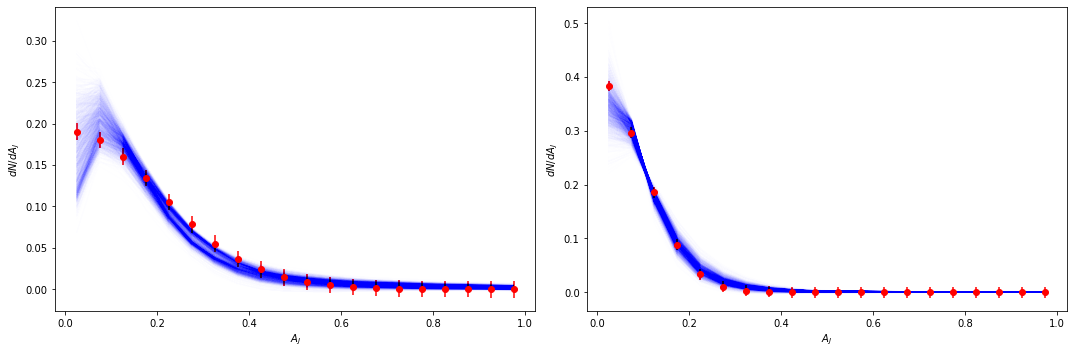

In [19]:
Examples = MCMCSamples[ np.random.choice(range(len(MCMCSamples)), 2000), :]

TempPrediction = {"PbPb5020": EmulatorPbPb5020.predict(Examples)}

SystemCount = len(AllData["systems"])

figure, axes = plt.subplots(figsize = (15, 5 * SystemCount), ncols = 2, nrows = 1)

for s2 in range(0, 2):
    axes[s2].set_xlabel(r"$A_{J}$")
    axes[s2].set_ylabel(r"$dN/dA_{J}$")
        
    S1 = AllData["systems"][0]
    O  = AllData["observables"][0][0]
    S2 = AllData["observables"][0][1][s2]
        
    DX = AllData["data"][S1][O][S2]['x']
    DY = AllData["data"][S1][O][S2]['y']
    DE = np.sqrt(AllData["data"][S1][O][S2]['yerr']['stat'][:,0]**2 + AllData["data"][S1][O][S2]['yerr']['sys'][:,0]**2)
                
    for i, y in enumerate(TempPrediction[S1][O][S2]):
        axes[s2].plot(DX, y, 'b-', alpha=0.005, label="Posterior" if i==0 else '')
    axes[s2].errorbar(DX, DY, yerr = DE, fmt='ro', label="Measurements")

plt.tight_layout(True)
figure.savefig('ObservablePosterior.pdf', dpi = 192)
# figure

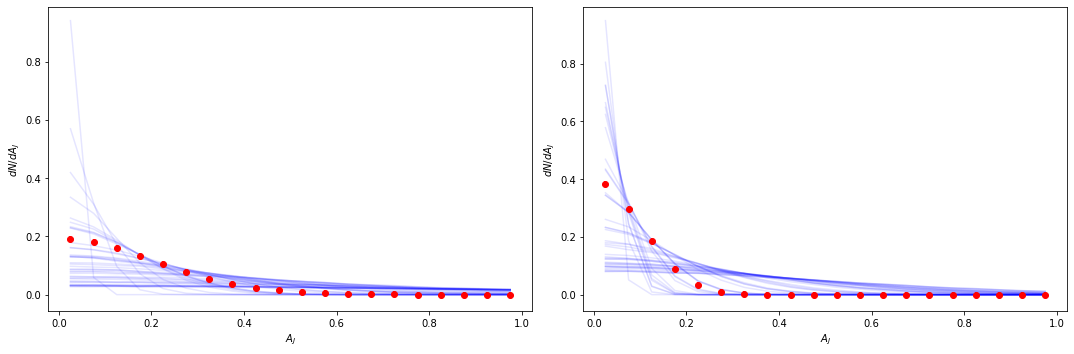

In [20]:
TempPrediction = AllData["model"]

figure, axes = plt.subplots(figsize = (15, 5 * SystemCount), ncols = 2, nrows = 1)

for s2 in range(0, 2):
    axes[s2].set_xlabel(r"$A_{J}$")
    axes[s2].set_ylabel(r"$dN/dA_{J}$")
        
    S1 = AllData["systems"][0]
    O  = AllData["observables"][0][0]
    S2 = AllData["observables"][0][1][s2]
        
    DX = AllData["data"][S1][O][S2]['x']
    DY = AllData["data"][S1][O][S2]['y']
    DE = np.sqrt(AllData["data"][S1][O][S2]['yerr']['stat'][:,0]**2 + AllData["data"][S1][O][S2]['yerr']['sys'][:,0]**2)
                
    for i, y in enumerate(TempPrediction[S1][O][S2]['Y']):
        axes[s2].plot(DX, y, 'b-', alpha=0.1, label="Posterior" if i==0 else '')
    axes[s2].errorbar(DX, DY, yerr = DE, fmt='ro', label="Measurements")

plt.tight_layout(True)
figure.savefig('Design.pdf', dpi = 192)
# figure

In [21]:
# close all plots to save memory
plt.close('all')